Unique item_date: 28
Unique customer: 723
Unique material_ref: 5984
Unique product_ref: 30
Unique delivery date: 20
Shape before cleaning: (25244, 14)
Missing values before cleaning:
id                   1
item_date            0
quantity tons        0
customer             0
country              0
status               0
item type            0
application          0
thickness            0
width                0
material_ref     11206
product_ref          1
delivery date        1
selling_price        1
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25244 entries, 0 to 25243
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             25243 non-null  object 
 1   item_date      25244 non-null  int64  
 2   quantity tons  25244 non-null  float64
 3   customer       25244 non-null  int64  
 4   country        25244 non-null  int64  
 5   status         25244 non-null  object 
 6   item type      2

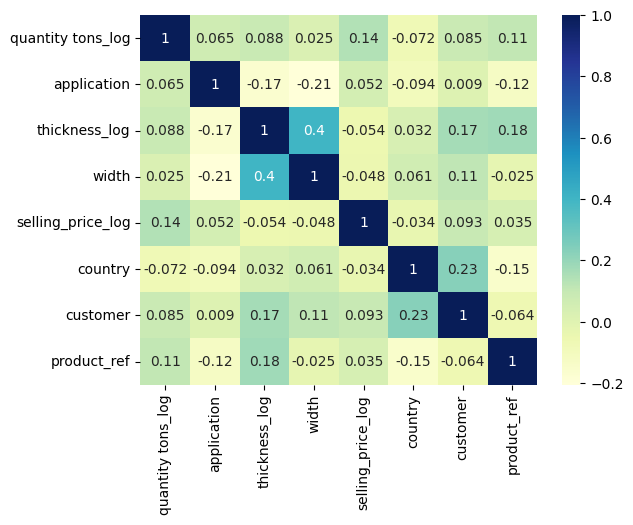

NaN in X: 0, NaN in y: 0
y_train NaN count: 0, y_test NaN count: 0
Decision Tree Regressor
Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10}
Mean Squared Error: 0.12734711453832814
R-Squared: 0.7433187874367307
Classifier Accuracy: 0.9466357308584686
Confusion Matrix:
[[ 514  111]
 [ 119 3566]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       625
           1       0.97      0.97      0.97      3685

    accuracy                           0.95      4310
   macro avg       0.89      0.90      0.89      4310
weighted avg       0.95      0.95      0.95      4310



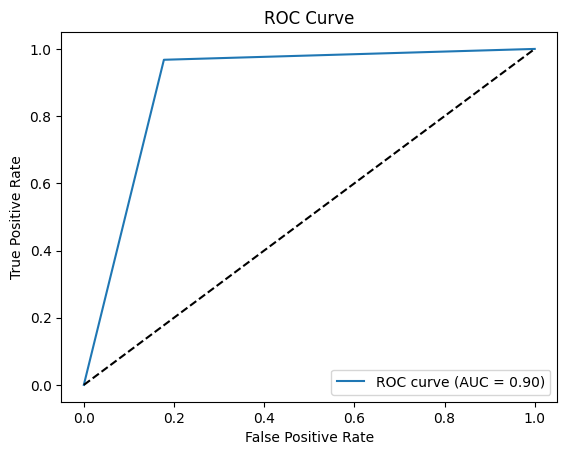

Regressor Prediction (log scale): [7.05272537]
Regressor Prediction (original scale): [1156.004995]
Classifier Prediction: ['Won']


In [6]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
import pickle

# Load the dataset
df = pd.read_csv("Copper_Set.xlsx - Result 1.csv")

# Initial checks
print("Unique item_date:", len(df['item_date'].unique()))
print("Unique customer:", len(df['customer'].unique()))
print("Unique material_ref:", len(df['material_ref'].unique()))
print("Unique product_ref:", len(df['product_ref'].unique()))
print("Unique delivery date:", len(df['delivery date'].unique()))

# Check for missing values and data types
print("Shape before cleaning:", df.shape)
print("Missing values before cleaning:")
print(df.isnull().sum())
df.info()

# Data Cleaning
df['item_date'] = pd.to_datetime(df['item_date'], format='%Y%m%d', errors='coerce').dt.date
df['quantity tons'] = pd.to_numeric(df['quantity tons'], errors='coerce')
df['customer'] = pd.to_numeric(df['customer'], errors='coerce')
df['country'] = pd.to_numeric(df['country'], errors='coerce')
df['application'] = pd.to_numeric(df['application'], errors='coerce')
df['thickness'] = pd.to_numeric(df['thickness'], errors='coerce')
df['width'] = pd.to_numeric(df['width'], errors='coerce')
df['material_ref'] = df['material_ref'].str.lstrip('0')
df['product_ref'] = pd.to_numeric(df['product_ref'], errors='coerce')
df['delivery date'] = pd.to_datetime(df['delivery date'], format='%Y%m%d', errors='coerce').dt.date
df['selling_price'] = pd.to_numeric(df['selling_price'], errors='coerce')

# Fill and drop missing values
df['material_ref'].fillna('unknown', inplace=True)
df.dropna(inplace=True)

# Log transformations for skewed features
df['selling_price_log'] = np.log(df['selling_price'].replace({0: np.nan}).dropna())
df['quantity tons_log'] = np.log(df['quantity tons'].replace({0: np.nan}).dropna())
df['thickness_log'] = np.log(df['thickness'].replace({0: np.nan}).dropna())
df.dropna(inplace=True)

# Correlation heatmap
x = df[['quantity tons_log', 'application', 'thickness_log', 'width', 'selling_price_log', 'country', 'customer', 'product_ref']].corr()
sns.heatmap(x, annot=True, cmap="YlGnBu")
plt.show()

# Decision Tree Regressor
X = df[['quantity tons_log', 'application', 'thickness_log', 'width', 'country', 'customer', 'product_ref']]
y = df['selling_price_log']

# Ensure no NaN in target
print(f"NaN in X: {X.isnull().sum().sum()}, NaN in y: {y.isnull().sum()}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"y_train NaN count: {np.isnan(y_train).sum()}, y_test NaN count: {np.isnan(y_test).sum()}")

# Hyperparameter Tuning
dtr = DecisionTreeRegressor()
param_grid = {
    'max_depth': [2, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Decision Tree Regressor")
print("Best Hyperparameters:", grid_search.best_params_)
print("Mean Squared Error:", mse)
print("R-Squared:", r2)

# Save the model
with open('regressor_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Decision Tree Classifier
df_c = df[df['status'].isin(['Won', 'Lost'])]
Y = df_c['status']
X = df_c[['quantity tons_log', 'selling_price_log', 'item type', 'application', 'thickness_log', 'width', 'country', 'customer', 'product_ref']]

# Encoding
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[['item type']])
X_ohe = ohe.transform(X[['item type']]).toarray()

be = LabelBinarizer()
be.fit(Y)
y = be.transform(Y)

X = np.concatenate((
    X[['quantity tons_log', 'selling_price_log', 'application', 'thickness_log', 'width', 'country', 'customer', 'product_ref']].values,
    X_ohe
), axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier Accuracy: {accuracy}")
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Save classifier model
with open('classifier_model.pkl', 'wb') as file:
    pickle.dump(dtc, file)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Prediction Code

# For Regressor Model
with open('regressor_model.pkl', 'rb') as file:
    regressor_model = pickle.load(file)

# Example input for the regressor (ensure the structure matches X used during training)
regressor_input = pd.DataFrame({
    'quantity tons_log': [np.log(10)],
    'application': [1],
    'thickness_log': [np.log(0.5)],
    'width': [1500],
    'country': [1],
    'customer': [12345],
    'product_ref': [67890]
})
regressor_prediction = regressor_model.predict(regressor_input)
print(f"Regressor Prediction (log scale): {regressor_prediction}")
print(f"Regressor Prediction (original scale): {np.exp(regressor_prediction)}")

# For Classifier Model
with open('classifier_model.pkl', 'rb') as file:
    classifier_model = pickle.load(file)

# Example input for the classifier (ensure the structure matches X used during training)
classifier_input = pd.DataFrame({
    'quantity tons_log': [np.log(10)],
    'selling_price_log': [np.log(5000)],
    'item type': ['A'],  # replace with an example item type
    'application': [1],
    'thickness_log': [np.log(0.5)],
    'width': [1500],
    'country': [1],
    'customer': [12345],
    'product_ref': [67890]
})

# Encode 'item type' and scale the input
classifier_input_ohe = ohe.transform(classifier_input[['item type']]).toarray()
classifier_input_combined = np.concatenate((
    classifier_input[['quantity tons_log', 'selling_price_log', 'application', 'thickness_log', 'width', 'country', 'customer', 'product_ref']].values,
    classifier_input_ohe
), axis=1)
classifier_input_scaled = scaler.transform(classifier_input_combined)

classifier_prediction = classifier_model.predict(classifier_input_scaled)
print(f"Classifier Prediction: {be.inverse_transform(classifier_prediction)}")
